In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.optimizers import Nadam
from sklearn.preprocessing import StandardScaler
import warnings
import pickle
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Precision, Recall
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from imblearn.over_sampling import SMOTE




In [167]:
df = pd.read_parquet('../datasets/datasets_entrenamieto/Dataset_binario.parquet')

In [200]:
df.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,54.00,6.00,64.00,0.755172,0.755172,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.333187e+07,9.5,10.392305,0.000000,0.000000e+00,0.00,141.55,1
1,0.017902,782.56,6.00,64.59,56.336008,56.336008,0.0,0.0,0.0,0.0,...,0.447587,54.39,8.331408e+07,9.5,10.402787,0.635935,4.048129e+00,0.05,141.55,1
2,0.052243,89.06,6.11,64.00,19.297399,19.297399,0.0,0.0,0.0,0.0,...,0.026812,53.96,8.331399e+07,9.5,10.391685,0.038221,2.435074e-02,0.03,141.55,1
3,25.823692,1944859.20,7.10,78.60,63.355780,63.355780,0.0,0.0,0.0,0.0,...,2334.163342,2526.40,1.665199e+08,13.5,49.962709,3307.011496,6.169782e+06,1.00,244.60,0
4,6.937773,9616.70,14.80,108.10,47.489550,47.489550,0.0,0.0,0.0,0.0,...,53.240355,103.60,1.665239e+08,13.5,14.542048,74.757580,2.799340e+03,1.00,244.60,0


In [169]:
df.shape

(75372, 47)

In [170]:
df['label'].unique()

array(['malware', 'BenignTraffic'], dtype=object)

## Asignación de variables numéricas a las etiquetas

In [171]:
df['label'][df['label']=='malware'] = 1

In [172]:
df['label'][df['label']=='BenignTraffic'] = 0

In [173]:
df['label'] = df['label'].astype(int)

## Aumento de datos con smote

Luego de realizar varias pruebas y observar sobreajuste en el modelo, decidí recurrir a técnicas de data augmentation como smote.

In [174]:
X = df.drop('label', axis=1)
y = df['label']

In [175]:
smote = SMOTE()


In [176]:
X_sm, y_sm = smote.fit_resample(X, y)

Creo un dataframe nuevo con los datos sintéticos.

In [177]:
df_aumentado = pd.concat([pd.DataFrame(X_sm, columns=X.columns), pd.Series(y_sm, name='label')], axis=1)

Verifico.

In [178]:
df_aumentado.shape

(78408, 47)

In [179]:
df_aumentado['label'].unique()

array([1, 0])

Concateno los datos creados con smote con el df original.

In [180]:
df = pd.concat([df, df_aumentado])

In [181]:
df.shape

(153780, 47)

## Asignación de X e y (arrays)

In [182]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [183]:
df.iloc[:, :-1]

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,0.000000,5.400000e+01,6.000000,64.000000,0.755172,0.755172,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.000000,8.333187e+07,9.5,10.392305,0.000000,0.000000e+00,0.000000,141.55
1,0.017902,7.825600e+02,6.000000,64.590000,56.336008,56.336008,0.0,0.0,0.0,0.0,...,54.109009,0.447587,54.390000,8.331408e+07,9.5,10.402787,0.635935,4.048129e+00,0.050000,141.55
2,0.052243,8.906000e+01,6.110000,64.000000,19.297399,19.297399,0.0,0.0,0.0,0.0,...,53.993673,0.026812,53.960000,8.331399e+07,9.5,10.391685,0.038221,2.435074e-02,0.030000,141.55
3,25.823692,1.944859e+06,7.100000,78.600000,63.355780,63.355780,0.0,0.0,0.0,0.0,...,1288.936668,2334.163342,2526.400000,1.665199e+08,13.5,49.962709,3307.011496,6.169782e+06,1.000000,244.60
4,6.937773,9.616700e+03,14.800000,108.100000,47.489550,47.489550,0.0,0.0,0.0,0.0,...,106.352256,53.240355,103.600000,1.665239e+08,13.5,14.542048,74.757580,2.799340e+03,1.000000,244.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78403,31.860618,9.675582e+02,11.630763,78.876440,36.766655,36.766655,0.0,0.0,0.0,0.0,...,122.745903,67.244746,80.530959,1.665205e+08,13.5,15.665170,95.195840,4.551595e+03,1.000000,244.60
78404,14.770410,5.476206e+05,6.390008,114.898551,79.693904,79.693904,0.0,0.0,0.0,0.0,...,1061.971751,1094.249809,1507.478756,5.269726e-03,5.5,41.738500,1547.502921,1.638459e+06,0.770911,38.50
78405,38.117159,8.984971e+03,8.168788,81.843327,3.121561,3.121561,0.0,0.0,0.0,0.0,...,173.775434,151.035861,173.155928,1.665248e+08,13.5,18.607678,214.065296,2.448807e+04,1.000000,244.60
78406,47.979774,5.006432e+03,7.351769,168.346316,1.056386,1.056386,0.0,0.0,0.0,0.0,...,105.039363,56.217766,107.035573,1.665171e+08,13.5,14.485061,79.681479,3.204168e+03,1.000000,244.60


## Separación en conjunto de entrenamiento y de prueba

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=83)

## Normalización de datos

Se instancia el escalador.

In [185]:
scaler = StandardScaler()

Se escalan los valores de X_train y X_test.

In [186]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Se guarda el escalador para usarlo con los valores de prueba del modelo

In [ ]:
with open('../creacion_modelo/Modelos entrenados/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [187]:
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

## Callbacks



### Callback de corte

Este callback verifica el valor de accuracy al final de cada ciclo de entrenamiento. Si accuracy supera el 98 % corta el entrenaiento, optimizando recursos.

In [188]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.98):
      print("\n¡Accuracy >= 98%!")
      self.model.stop_training = True

In [189]:
callback_end = myCallback()


### EarlyStopping:

Monitorea val_accuracy y corta el entrenamiento si se estanca en un mínimo local. Solo lo uso para las pruebas previas al modelo final.


### ModelCheckpoint:

Este callback verifica al final de cada iteración val_accuracy y siempre guarda el mejor modelo en función de esta métrica.


### ReduceLROnPlateau:

Monitorea val_accuracy en cada epoch y, si queda en un mínimo local, baja el parámetro learning_rate.

In [190]:
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=100, min_delta=0.003, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='../modelos_entrenados/modelo.h5', monitor='val_accuracy', save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-6)
callbacks = [reduce_lr, model_checkpoint, callback_end]

## Creación del modelo

El modelo está compuesto por capas convolucionales para extraer mejor características, capas de agrupamiento, capas de normalización, capas densas y capas de dropout para evitar el sobreajuste. Además, también para evitar el sobreajuste, se utiliza regularización L2.

In [191]:
model = Sequential([
        Conv1D(128, 3, activation='relu', input_shape=(X_train.shape[1], 1), padding='same'),
        MaxPooling1D(2),
        Conv1D(256, 3, activation='relu',  padding='same'),
        BatchNormalization(),
        Conv1D(512, 3, activation='relu',  padding='same', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(2),
        Flatten(),
        Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dense(1024, activation='relu'),
        Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(512, activation='sigmoid'),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')])


## Compilación del modelo

Se especifican el optimizador, la tasa de aprendizaje, la función de pérdida y las métricas.

In [192]:
model.compile(optimizer=Nadam(learning_rate=0.00038), loss= 'binary_crossentropy' , metrics=['accuracy', Precision(), Recall()])

## Entrenamiento del modelo

Se especifican la cantidad de iteraciones, el tamaño de cada lote que debe procesar y los callbacks utilizados.

In [193]:
historial = model.fit(X_train_scaled, y_train, epochs=75, batch_size=1024, validation_data=(X_test_scaled, y_test), callbacks=callbacks)

Epoch 1/75
128/128 [==============================] - 13s 52ms/step - loss: 2.7392 - accuracy: 0.8890 - precision_5: 0.9032 - recall_5: 0.8762 - val_loss: 1.3500 - val_accuracy: 0.5093 - val_precision_5: 0.5093 - val_recall_5: 1.0000 - lr: 3.8000e-04
Epoch 2/75
128/128 [==============================] - 4s 34ms/step - loss: 0.4531 - accuracy: 0.9107 - precision_5: 0.9196 - recall_5: 0.9039 - val_loss: 0.7637 - val_accuracy: 0.5093 - val_precision_5: 0.5093 - val_recall_5: 1.0000 - lr: 3.8000e-04
Epoch 3/75
128/128 [==============================] - 5s 37ms/step - loss: 0.2694 - accuracy: 0.9120 - precision_5: 0.9199 - recall_5: 0.9064 - val_loss: 0.6717 - val_accuracy: 0.5475 - val_precision_5: 0.5297 - val_recall_5: 0.9951 - lr: 3.8000e-04
Epoch 4/75
128/128 [==============================] - 5s 36ms/step - loss: 0.2361 - accuracy: 0.9139 - precision_5: 0.9222 - recall_5: 0.9078 - val_loss: 0.4245 - val_accuracy: 0.7868 - val_precision_5: 0.7148 - val_recall_5: 0.9671 - lr: 3.8000e-04

## Función para mostrar las métricas

In [194]:
def grafico_metricas(historial:any, metricas:list) -> None:
    for metrica in metricas:
        plt.plot(historial.history[metrica])
    plt.xlabel("Epochs")
    plt.legend(metricas)
    plt.show()

## Gráfico de la función de pérdida

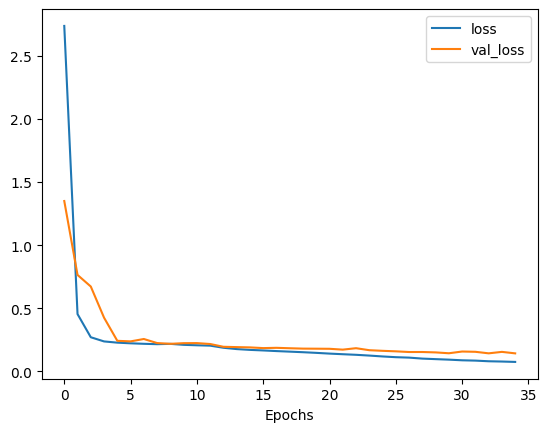

In [195]:
grafico_metricas(historial, ['loss', 'val_loss'])

## Gráfico de accuracy y val_accuracy

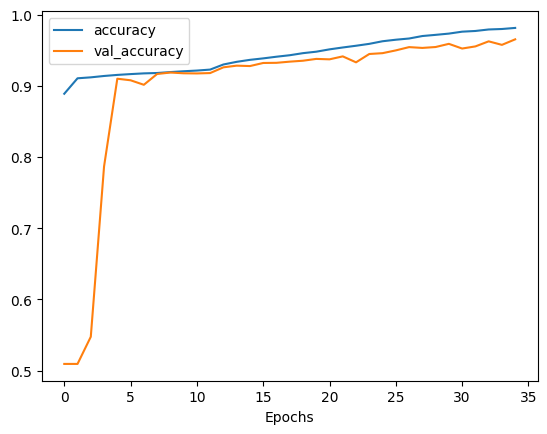

In [196]:
grafico_metricas(historial, ['accuracy', 'val_accuracy'])

## Gráfico de tasa de aprendizaje

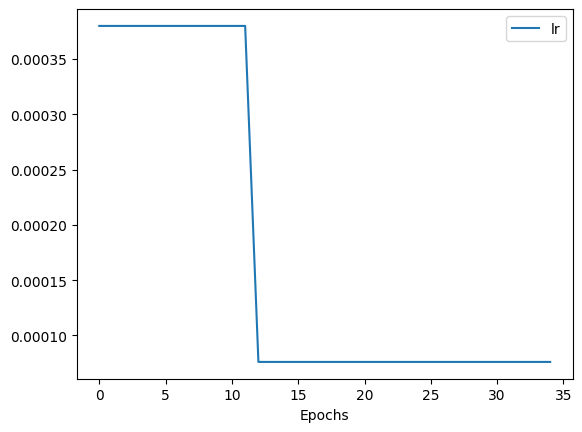

In [197]:
grafico_metricas(historial, ['lr'])

## Evaluación del modelo

In [198]:
model.evaluate(X_train_scaled, y_train)

4085/4085 [==============================] - 12s 3ms/step - loss: 0.0675 - accuracy: 0.9839 - precision_5: 0.9839 - recall_5: 0.9844


[0.06747422367334366, 0.9838577508926392, 0.983940839767456, 0.984413206577301]

In [199]:
model.evaluate(X_test_scaled, y_test)

721/721 [==============================] - 2s 3ms/step - loss: 0.1414 - accuracy: 0.9655 - precision_5: 0.9683 - recall_5: 0.9638


[0.14141197502613068,
 0.9654918313026428,
 0.9682770371437073,
 0.9638267159461975]